***Title: Does the multi-channel Platen method agree with qutip for long times?***  
***Date: 06/03/17***

In [2]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import csv
import os
cwd = os.getcwd()
%matplotlib inline
pylab.rcParams['figure.figsize'] = (12, 8)

In [37]:
def photon_probabilities_qload(folder_path):
    cwd = os.getcwd()
    expectations_path = folder_path + '/expectations'
    expectations = qload(expectations_path)
    probabilities = np.array([expectations[x] for x in range(0, len(expectations))]);
    return probabilities

def mean_photons_calc(probabilities):
    photons = np.zeros(probabilities.shape[1])
    for i in range(photons.shape[0]):
        for j in range(probabilities.shape[0]):
            photons[i] = photons[i] + j * probabilities[j, i]
    return photons

def csv_load(file_path):
    zeroth_row = True
    with open(file_path , 'rb') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            if zeroth_row == True:
                row.remove('')
                row = [float(value) for value in row]
                data = np.array(row)
                zeroth_row = False
            else:
                row.remove('')
                new_row = [float(value) for value in row]
                data = np.vstack([data, new_row])
    return data

def times_qload(folder_path):
    times_path = folder_path + '/times'
    times = qload(times_path)
    times = times / (2 * np.pi * 1000)
    return times

def plot_comparison(times, data_sets, title='', xlabel=r'Time / $\mu$s', ylabel='Photons', fontsize=16, legend=False, loc=0):
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    for data in data_sets:
        plt.plot(times[0:len(data)], data)
    plt.title(title, fontsize=fontsize)
    plt.xlabel(xlabel, fontsize=fontsize)
    plt.ylabel(ylabel, fontsize=fontsize)
    if legend:
        plt.legend(legend, loc=loc)
    plt.tick_params(axis='both', labelsize=18)
    return plt

Loaded list object.
Loaded ndarray object.
Loaded list object.


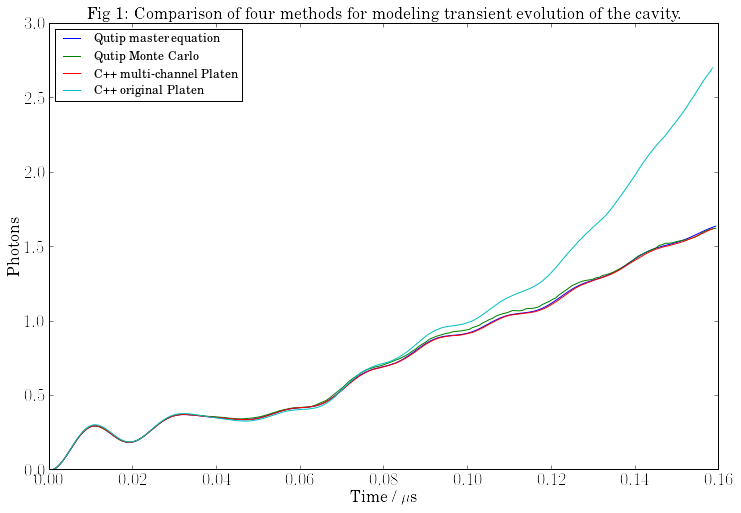

In [41]:
folder_path = cwd + '/master_standard/2017-02-24--14-56-01'
cavity_occupations_short_master = photon_probabilities_qload(folder_path)
photons_short_master = mean_photons_calc(cavity_occupations_short_master)
times = times_qload(folder_path)

folder_path = cwd + '/monte_test/2017-02-28--12-38-10'
cavity_occupations_short_monte = photon_probabilities_qload(folder_path)
photons_short_monte = mean_photons_calc(cavity_occupations_short_monte)

folder_path = cwd + '/multi_noise_verification/2017.02.23--10-33-12/photon_histogram.dat'
cavity_occupations_short_multi = csv_load(folder_path)
photons_short_multi = mean_photons_calc(cavity_occupations_short_multi)

folder_path = cwd + '/diffusive_failure/2017.02.22--19-57-30/photon_histogram.dat'
cavity_occupations_short_original = csv_load(folder_path)
photons_short_original = mean_photons_calc(cavity_occupations_short_original)

legend = ['Qutip master equation', 'Qutip Monte Carlo', 'C++ multi-channel Platen', 'C++ original Platen']
title = 'Fig 1: Comparison of four methods for modeling transient evolution of the cavity.'
data_sets = [photons_short_master, photons_short_monte, photons_short_multi, photons_short_original]
handle = plot_comparison(times, data_sets, legend=legend, title=title)

Fig 1: Previously I demonstrated that modifying our C++ code to use the Platen method with a Wiener increment for each channel (described in Platen and Kloeden) produced much closer agreement with the qutip master equation solver. These results are repeated above. The next task is to find out if the multi-channel method agrees with qutip in the steady state.  
  
  For reference here are the parameters of the system:  
$\kappa = 1$ MHz  
$\gamma = 1$ MHz  
$g = 309.6$ MHz  
$\epsilon = 4$ MHz  
$\omega_c = 10.4267$ GHz  
$\omega_q = 9.39128$ GHz  
$\omega_d = 10.5066$ GHz  
$\delta = \omega_q - \omega_c = -1.03542$ GHz  
$\chi = -97$ MHz  
with the transmon and the cavity starting in their ground states. These parameters are stored in the following file:

In [42]:
cat ./multi_noise_verification/2017.02.23--10-33-12/settings.cfg

folder=multi_noise_verification
endtime=1.0000000000e+03
transmon_levels=5
cavity_levels=20
snap_to_snap=250
bins=50000
snapshots_number=200
kappa=1.0000000000e-03
gamma_c=1.0000000000e-03
g=3.0960000000e-01
epsilon=4.0000000000e-03
omega_c=1.0426700000e+01
omega_q=9.3912800000e+00
omega_d=1.0506600000e+01
theta=3.1415926540e+00
phi=0.0000000000e+00
samplesize=10000
photon_number=0
chi=-9.7000000000e-02


Loaded Qobj object:
Quantum object: dims = [[20, 5], [20, 5]], shape = [100, 100], type = oper, isHerm = True

4.29897993129


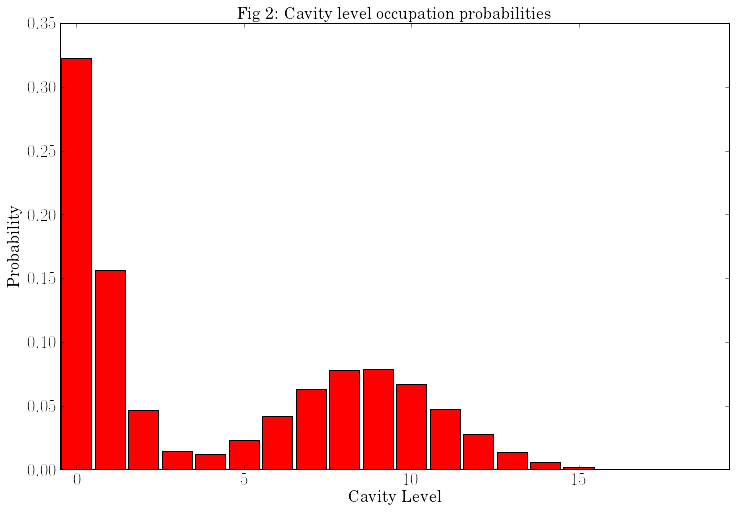

In [43]:
rho_ss = qload(cwd + '/qutip_steady_state_dip/density_matrix')
rho_c_ss = rho_ss.ptrace(0)
cavity_occupations_qutip = rho_c_ss.diag()

mean = mean_photons_calc(np.array([cavity_occupations_qutip]))

width = 0.9
fontsize = 16
ind = np.arange(cavity_occupations_qutip.size)
fig, ax = plt.subplots()
plot_qutip = ax.bar(ind - width/2, cavity_occupations_qutip, width, color='r')
ax.set_title('Fig 2: Cavity level occupation probabilities', fontsize=fontsize)
ax.set_xlabel('Cavity Level', fontsize=fontsize)
ax.set_xlim([-0.5, 19.5])
ax.set_ylabel('Probability', fontsize=fontsize)
ax.tick_params(axis='both', labelsize=18)

cavity_occupations_qutip = np.array([cavity_occupations_qutip])
cavity_occupations_qutip = np.swapaxes(cavity_occupations_qutip, 0, 1)
mean_photons = mean_photons_calc(cavity_occupations_qutip)
print mean_photons[0]

Fig 2: Qutip has a tool to find the steady state density matrix of a master equation. Above we can see the predicted cavity level occupations in the steady state. As you can see the system displays bistabiilty in this parameter regime. The expected number of photons on the resonator is 4.3.

Loaded list object.
Loaded ndarray object.


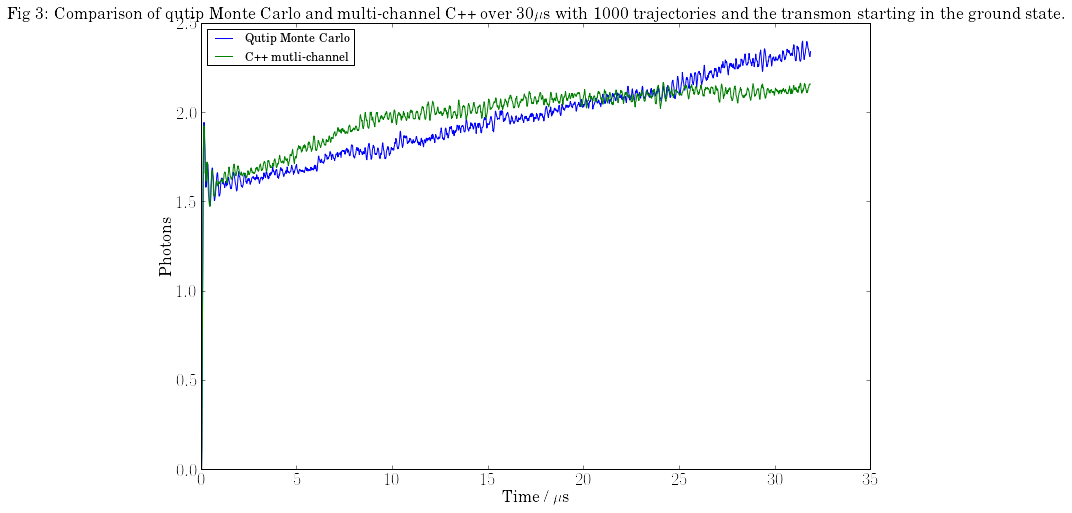

In [67]:
folder_path = cwd + '/monte_long_time/2017-02-28--21-39-53'
cavity_occupations_long_monte = photon_probabilities_qload(folder_path)
photons_long_monte = mean_photons_calc(cavity_occupations_long_monte)
times = times_qload(folder_path)

folder_path = cwd + '/multi_noise/steady_state_dip/2017.02.23--22-04-32/photon_histogram.dat'
cavity_occupations_long_multi = csv_load(folder_path)
photons_long_multi = mean_photons_calc(cavity_occupations_long_multi)

legend = ['Qutip Monte Carlo', 'C++ mutli-channel']
title = r'Fig 3: Comparison of qutip Monte Carlo and multi-channel C++ over 30$\mu$s with 1000 trajectories and the transmon starting in the ground state.'
handle = plot_comparison(times, [photons_long_monte, photons_long_multi], legend=legend, title=title)

Fig 3: Comparing the results of the qutip Monte Carlo method with the multi-channel C++ code for 1000 trajectories over  a period of about 30$\mu$s we notice two problems. Firstly, I'm a bit disappointed with the level of agreement between the two methods. Although they follow each other closely for the first couple of microseconds this deteriorates for longer times. Second, it's difficult to tell if steady state has been reached. The Monte Carlo simulation indicates that it hasn't yet reached steady state but the C++ results appear to be converging to a steady value at around 2.1 photons much different from the qutip prediction of 4.3.

Loaded list object.
Loaded ndarray object.


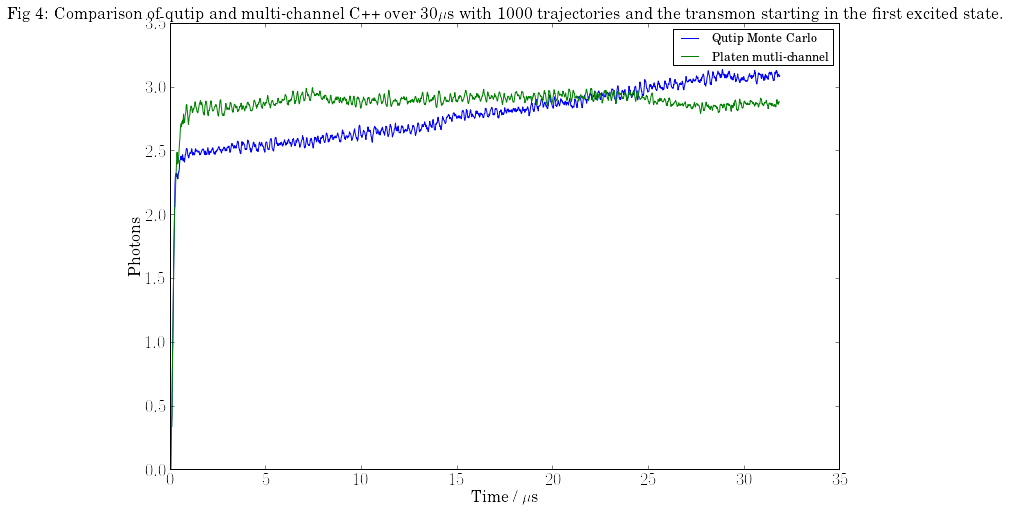

In [68]:
folder_path = cwd + '/monte_long_time/2017-02-28--14-47-21'
cavity_occupations_long_monte = photon_probabilities_qload(folder_path)
photons_long_monte = mean_photons_calc(cavity_occupations_long_monte)
times = times_qload(folder_path)

folder_path = cwd + '/multi_noise/steady_state_dip/2017.02.28--16-18-53/photon_histogram.dat'
cavity_occupations_long_multi = csv_load(folder_path)
photons_long_multi = mean_photons_calc(cavity_occupations_long_multi)

legend = ['Qutip Monte Carlo', 'Platen mutli-channel']
title = r'Fig 4: Comparison of qutip and multi-channel C++ over 30$\mu$s with 1000 trajectories and the transmon starting in the first excited state.'
handle = plot_comparison(times, [photons_long_monte, photons_long_multi], legend=legend, title=title)

Fig 4: With the transmon starting in the first excited state we see even worse agreement between the two methods. The C++ results appear to be converging to a steady state around 2.8 photons.
  
  Themis has suggested that disagreement we see between qutip and the C++ code could be due to the presence of bistability in this parameter regime. Bistability causes trajectories to be very noisy and basically means we require more of them to obtain accurate expectation values.

Loaded Qobj object:
Quantum object: dims = [[20, 5], [20, 5]], shape = [100, 100], type = oper, isHerm = True

0.0334494648752


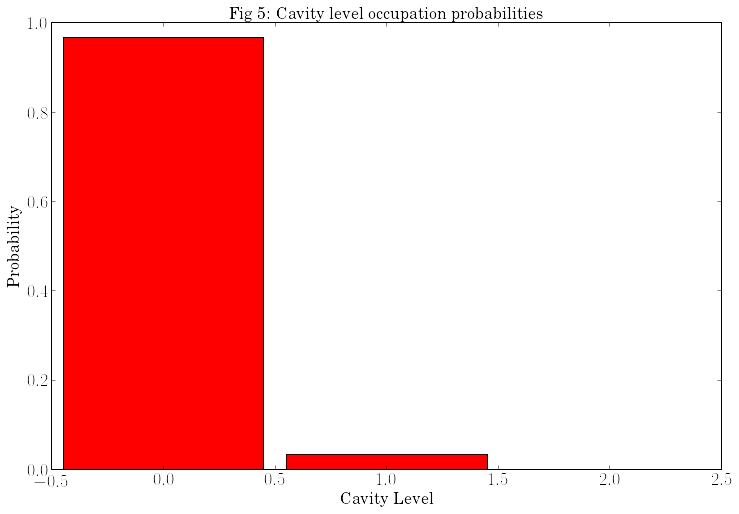

In [53]:
rho_ss = qload(cwd + '/qutip_steady_state_low_power/density_matrix')
rho_c_ss = rho_ss.ptrace(0)
cavity_occupations_qutip = rho_c_ss.diag()

mean = mean_photons_calc(np.array([cavity_occupations_qutip]))

width = 0.9
fontsize = 16
ind = np.arange(cavity_occupations_qutip.size)
fig, ax = plt.subplots()
plot_qutip = ax.bar(ind - width/2, cavity_occupations_qutip, width, color='r')
ax.set_title('Fig 5: Cavity level occupation probabilities', fontsize=fontsize)
ax.set_xlabel('Cavity Level', fontsize=fontsize)
ax.set_xlim([-0.5, 2.5])
ax.set_ylabel('Probability', fontsize=fontsize)
ax.tick_params(axis='both', labelsize=18)

cavity_occupations_qutip = np.array([cavity_occupations_qutip])
cavity_occupations_qutip = np.swapaxes(cavity_occupations_qutip, 0, 1)
mean_photons = mean_photons_calc(cavity_occupations_qutip)
print mean_photons[0]

Fig 5: In order to check if bistability might be the cause of disagreement in Figs 2 and 3 I decided to carry out Monte Carlo and diffusive simulations far away from bistability. The following changes have been made:  
  
$\epsilon = 0.1$ MHz  
$\omega_d = 10.5122$ GHz  
  
  The steady state cavity level occupations are displayed above. The expected number of photons on the resonator is 0.0334.

Loaded list object.
Loaded ndarray object.
Loaded list object.


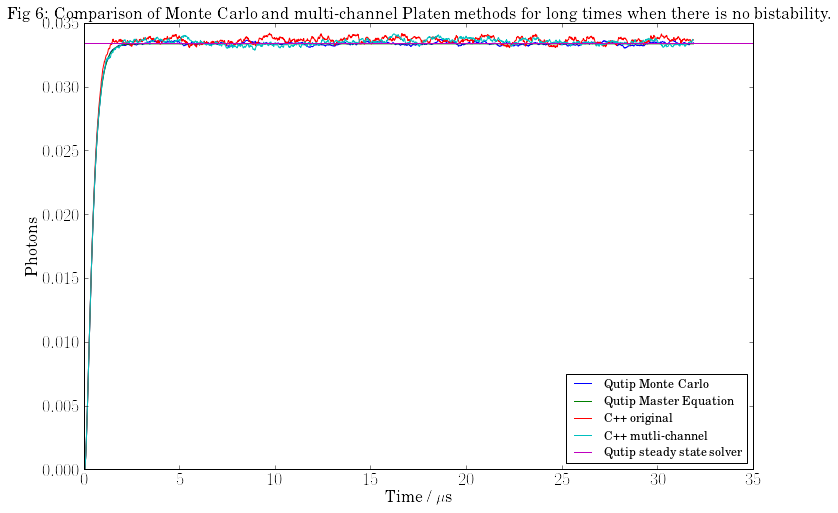

In [92]:
folder_path = cwd + '/monte_long_time_low_power/2017-02-28--23-55-37'
cavity_occupations_long_monte = photon_probabilities_qload(folder_path)
photons_long_monte = mean_photons_calc(cavity_occupations_long_monte)
times = times_qload(folder_path)

folder_path = cwd + '/master_steady_state_low_power/2017-03-06--14-14-56'
cavity_occupations_low_master = photon_probabilities_qload(folder_path)
photons_low_master = mean_photons_calc(cavity_occupations_low_master)

folder_path = cwd + '/multi_noise/steady_state_low_power/2017.02.28--22-09-19/photon_histogram.dat'
cavity_occupations_long_multi = csv_load(folder_path)
photons_long_multi = mean_photons_calc(cavity_occupations_long_multi)

folder_path = cwd + '/original_steady_state_low_power/2017.03.06--16-36-32/photon_histogram.dat'
original_occupations_low = csv_load(folder_path)
original_photons_low = mean_photons_calc(original_occupations_low)

legend = ['Qutip Monte Carlo', 'Qutip Master Equation', 'C++ original', 'C++ mutli-channel', 'Qutip steady state solver']
title = 'Fig 6: Comparison of Monte Carlo and multi-channel Platen methods for long times when there is no bistability.'
handle = plot_comparison(times, [photons_long_monte, photons_low_master, original_photons_low, photons_long_multi], legend=legend, title=title, loc=3)
handle.axhline(y=0.03344, xmin=0, xmax=30, linewidth=1, color = 'm')
handle.legend(legend, loc=4)

Fig 6: As before I used 1000 trajectories for each method. As you see above this is close agreement between qutip Monte Carlo, qutip master equation C++ original and C++ multi-channel Platen methods in the steady state. This suggests that I should try using more trajectories to get accurate results in the presence of bistability.

Loaded list object.
Loaded ndarray object.
Loaded list object.


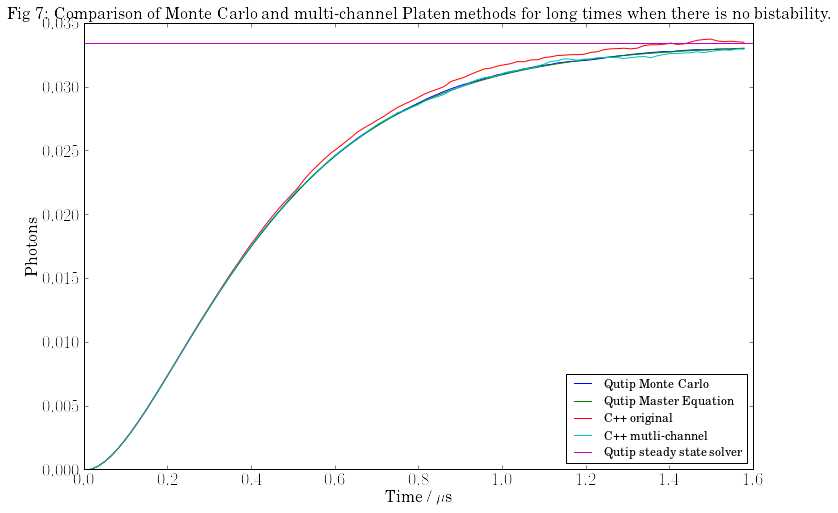

In [97]:
folder_path = cwd + '/monte_long_time_low_power/2017-02-28--23-55-37'
cavity_occupations_long_monte = photon_probabilities_qload(folder_path)
photons_long_monte = mean_photons_calc(cavity_occupations_long_monte)
times = times_qload(folder_path)

folder_path = cwd + '/master_steady_state_low_power/2017-03-06--14-14-56'
cavity_occupations_low_master = photon_probabilities_qload(folder_path)
photons_low_master = mean_photons_calc(cavity_occupations_low_master)

folder_path = cwd + '/multi_noise/steady_state_low_power/2017.02.28--22-09-19/photon_histogram.dat'
cavity_occupations_long_multi = csv_load(folder_path)
photons_long_multi = mean_photons_calc(cavity_occupations_long_multi)

folder_path = cwd + '/original_steady_state_low_power/2017.03.06--16-36-32/photon_histogram.dat'
original_occupations_low = csv_load(folder_path)
original_photons_low = mean_photons_calc(original_occupations_low)

cutoff = 100

legend = ['Qutip Monte Carlo', 'Qutip Master Equation', 'C++ original', 'C++ mutli-channel', 'Qutip steady state solver']
title = 'Fig 7: Comparison of Monte Carlo and multi-channel Platen methods for long times when there is no bistability.'
handle = plot_comparison(times[0:cutoff], [photons_long_monte[0:cutoff], photons_low_master[0:cutoff], original_photons_low[0:cutoff], photons_long_multi[0:cutoff]], legend=legend, title=title, loc=3)
handle.axhline(y=0.03344, xmin=0, xmax=30, linewidth=1, color = 'm')
handle.legend(legend, loc=4)

Fig 7: If we look closer at the earlier times in Fig 6 we can see that the results of the original C++ code (red) are noticably different from the results of the other methods but unlike in the case of Fig 1 (where we had bistability) the deviation is only a few percent.

Loaded list object.
Loaded ndarray object.
Loaded list object.
Loaded ndarray object.


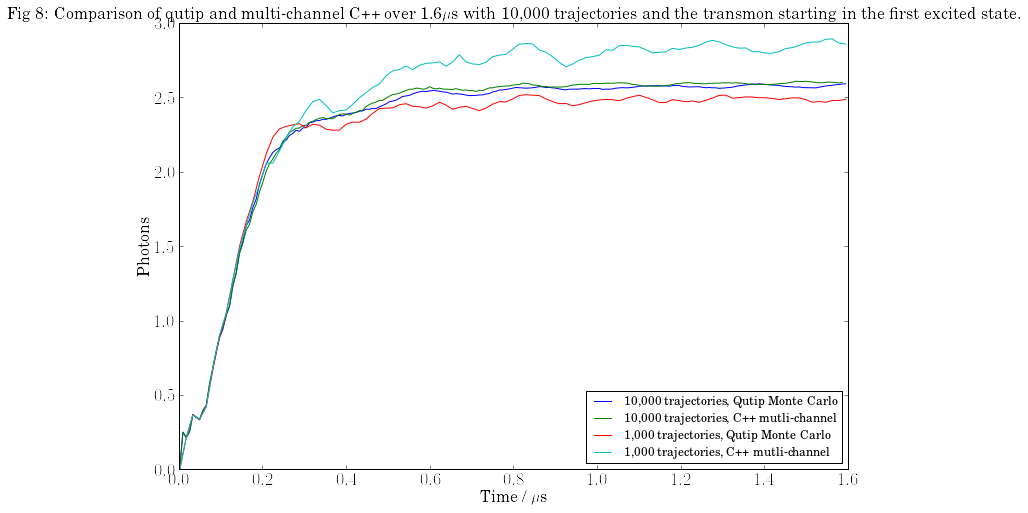

In [103]:
folder_path = cwd + '/monte_mid_time/2017-03-01--17-06-54'
cavity_occupations_long_monte = photon_probabilities_qload(folder_path)
photons_long_monte = mean_photons_calc(cavity_occupations_long_monte)
times = times_qload(folder_path)

folder_path = cwd + '/multi_noise/steady_state_dip_mid_time/2017.03.01--14-04-11/photon_histogram.dat'
cavity_occupations_long_multi = csv_load(folder_path)
photons_long_multi = mean_photons_calc(cavity_occupations_long_multi)

legend = ['10,000 trajectories, Qutip Monte Carlo', '10,000 trajectories, C++ mutli-channel', '1,000 trajectories, Qutip Monte Carlo', '1,000 trajectories, C++ mutli-channel']
title = r'Fig 8: Comparison of qutip and multi-channel C++ over 1.6$\mu$s with 10,000 trajectories and the transmon starting in the first excited state.'
handle = plot_comparison(times, [photons_long_monte, photons_long_multi], legend=legend, title=title)

folder_path = cwd + '/monte_long_time/2017-02-28--14-47-21'
cavity_occupations_long_monte = photon_probabilities_qload(folder_path)
photons_long_monte = mean_photons_calc(cavity_occupations_long_monte)
times = times_qload(folder_path)

folder_path = cwd + '/multi_noise/steady_state_dip/2017.02.28--16-18-53/photon_histogram.dat'
cavity_occupations_long_multi = csv_load(folder_path)
photons_long_multi = mean_photons_calc(cavity_occupations_long_multi)

cutoff = 101
handle.plot(times[0:cutoff], photons_long_monte[0:cutoff])
handle.plot(times[0:cutoff], photons_long_multi[0:cutoff])
handle.legend(legend, loc=4)

Fig 8: Repeating the first 1.6 $\mu$s of the simulations in Fig 4 and using 10,000 trajectories instead of 1,000 we see good agreement between Qutip Monte Carlo and C++ multi-channel methods.  
  
  What will we see if we repeat the full 30$\mu$s of the Fig 4 simulations? Repeating all of Fig 4 with 10,000 trajectories takes four days. Currently I am three days in and have finished the C++ simulation.

Loaded list object.
Loaded ndarray object.


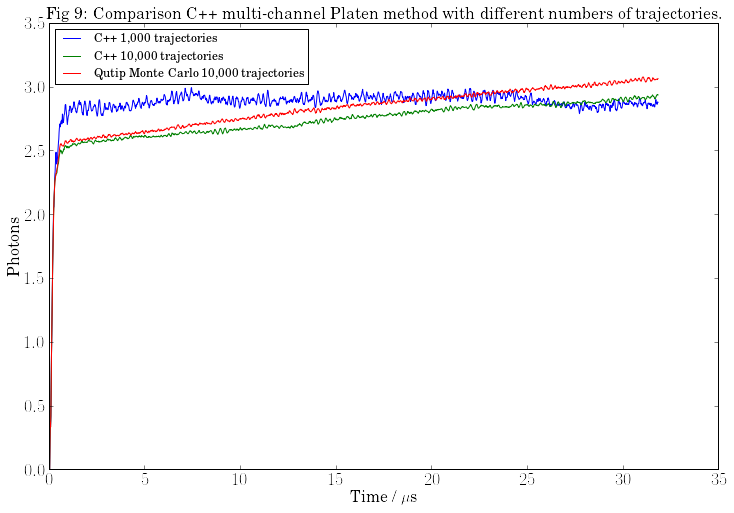

In [111]:
folder_path = cwd + '/monte_long_time_ensemble/2017-03-07--10-03-15'
cavity_occupations_long_monte = photon_probabilities_qload(folder_path)
photons_long_monte = mean_photons_calc(cavity_occupations_long_monte)
times = times_qload(folder_path)

folder_path = cwd + '/multi_noise/steady_state_dip/2017.02.28--16-18-53/photon_histogram.dat'
cavity_occupations_long_multi = csv_load(folder_path)
photons_long_multi = mean_photons_calc(cavity_occupations_long_multi)

folder_path = cwd + '/multi_noise/steady_state_dip_ensemble/2017.03.03--18-16-09/photon_histogram.dat'
cavity_occupations_long_multi_ensemble = csv_load(folder_path)
photons_long_multi_ensemble = mean_photons_calc(cavity_occupations_long_multi_ensemble)

cutoff = 1999
legend = ['C++ 1,000 trajectories', 'C++ 10,000 trajectories', 'Qutip Monte Carlo 10,000 trajectories']
title = r'Fig 9: Comparison C++ multi-channel Platen method with different numbers of trajectories.'
handle = plot_comparison(times[0:cutoff], [photons_long_multi[0:cutoff], photons_long_multi_ensemble[0:cutoff], photons_long_monte[0:cutoff]], legend=legend, title=title)

Fig 9: Using 10,000 trjajectories instead of 1,000 produces very different results. This indicates Themis is right to suggest that we need many more trajectories to get accurate averages in the region of bistability. There is good agreement at short times but at long times it appears that having 10,000 or more trajectories is very important.  
  
  Also, it appears to be taking over 30$\mu$s for the system to reach the steady state (4.3 photons). This is much greater than any time scale in the Hamiltonian.